## Build and track our portfolio based on our trades.

### Doesn't have any concept of buy and sell just yet.  only that a position is bought and held

In [38]:
import pandas as pd
import yfinance as yf
import plotly.graph_objects as go
import pylab
import requests as rq
import matplotlib

Spoofing the data for now. Could come from xlsx or  pull from broker if there is an API

In [2]:
# data = {'tickers': ['BTC-AUD', 'BOE.AX', 'PDN.AX', 'ETH-AUD', 'BOE.AX'] ,
#         'prices': [10000, 0.34, 0.40, 300.0, 0.4 ],
#         'amounts': [0.01, 3000, 2100, 0.11, -2000],  # negative amounts indicates a sell
#         'dates': ['2021-01-01', '2021-01-01', '2021-01-01', '2021-01-01', '2021-05-01'],
#         'type': ['crypto', 'equity', 'equity', 'crypto', 'equity' ],
#         'commodity': [None, 'U', 'U', None, 'U']}  # Spoofing for now. Could come from xlsx or  pull from broker if there is an API

We load the data into a pandas dataframe

Not Spoofing any more.  we're taking the data from a subset of our trades xlsx spreadsheet. 

In [3]:
trade_data = pd.read_csv('data/trades.csv', delimiter=',')

In [4]:
trade_data.head()

,tickers,dates,price,amounts,market,commodity,type
0,BMN.AX,2020-12-14,0.079,8200,ASX,NaN,NaN
1,BOE.AX,2020-12-14,0.092,5400,ASX,NaN,NaN
2,VMY.AX,2020-12-14,0.061,10000,ASX,NaN,NaN
3,ORI.AX,2021-01-01,15.130,51,ASX,NaN,NaN
4,AGE.AX,2021-01-07,0.014,50000,ASX,NaN,NaN


In [5]:
# trade_data.describe()

lets look for duplicate tickers meaning we have either bought or sold the same ticker more than once

In [6]:
type(trade_data['tickers'].unique())

numpy.ndarray

So we wish to see how each trade has done on a daily basis.  We will use yfinance for now, could get from any number of APIs 

If you haven't already, `pip install yfinance` in a terminal

Lets define some constants which we will use to setup the scope of our analysis

In [7]:
PERIOD = '1D' # Daily
END = '2021-06-28' #  could use datetime.now

In [8]:
quotes = [] # empty list for storing quotes

for ticker, date in zip(trade_data['tickers'], trade_data['dates'] ):
    _quote = yf.Ticker(ticker)
    quotes.append(_quote.history(period=PERIOD, start=date, end=END))

<!-- <div class="alert alert-danger" role="alert">
  ^^^ We  can see a few missing. Need to fix these later. 
</div> -->

In [9]:
quotes[0].head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2020-12-14,0.073,0.086,0.071,0.083,15209053,0,0
2020-12-15,0.081,0.088,0.074,0.084,15607527,0,0
2020-12-16,0.087,0.088,0.082,0.086,6854015,0,0
2020-12-17,0.082,0.084,0.080,0.080,3658742,0,0
2020-12-18,0.081,0.082,0.076,0.080,5227180,0,0


----------
Lets open some candlestick charts [Helpful link](https://coderzcolumn.com/tutorials/data-science/candlestick-chart-in-python-mplfinance-plotly-bokeh)  Lets use Plotly for now.  `pip install plotly`

To use Plotly need to install [Node.js](https://nodejs.org/en/download/current/)    Do this by typing into a terminal

`conda install jodejs`   
followed by:   
`jupyter labextension install @jupyterlab/plotly-extension`   
----------------

Now lets make a little dropdown box for us to chose the ticker we want to see below in the plot    
`conda install ipywidgets`    
`jupyter labextension install @jupyter-widgets/jupyterlab-manager`


In [10]:
from ipywidgets import interact, interact_manual

In [11]:
type(trade_data['tickers'])

pandas.core.series.Series

In [12]:
@interact()
def make_plot(ticker=trade_data['tickers']):

    ii = list(trade_data['tickers']).index(ticker)
    candlestick = go.Candlestick(x=quotes[ii].index,
                                open=quotes[ii]['Open'],
                                high=quotes[ii]['High'],
                                low=quotes[ii]['Low'],
                                close=quotes[ii]['Close'])

    fig = go.Figure(data=[candlestick])
    fig.update_layout(xaxis_rangeslider_visible=False,
                     title=trade_data['tickers'][ii],
                     template='plotly_dark')

    fig.show()

interactive(children=(Dropdown(description='ticker', options=('BMN.AX', 'BOE.AX', 'VMY.AX', 'ORI.AX', 'AGE.AX'…

Now we need to generate our port folio based on the ticker data.  Dealing with datetimes is always painful

In [13]:
from datetime import datetime
_dates = []

for date in trade_data['dates']:
    _dates.append(datetime.strptime(date, '%Y-%m-%d').date())


date_range = pd.date_range(start=min(_dates), end=END, freq='D')

In [14]:
df = None
portfolio = date_range.to_frame()
frames = [portfolio]

for ii in range(len(trade_data['tickers'])):
    frames.append(quotes[ii]['Close'] * trade_data['amounts'][ii])

df = pd.concat(frames, axis=1)
df = df.drop(df.columns[0], axis=1)

df.columns = trade_data['tickers']

portfolio = df;

In [15]:
portfolio.fillna(method='ffill', inplace=True)  ## forward fill.  so on weekends we carry forward Friday's value

In [16]:
portfolio['Total'] = portfolio.sum(axis=1)  # add to total as a column

In [17]:
portfolio

tickers,BMN.AX,BOE.AX,VMY.AX,ORI.AX,AGE.AX,PDN.AX,URA,NXE,VMY.AX,WGX.AX,...,BMN.AX,NST.AX,BOE.AX,MNO.V,LOT.AX,AGE.AX,VMY.AX,ENCUF,EQX,Total
2020-12-14,680.599974,491.399990,610.000007,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1781.999971
2020-12-15,688.799991,475.199997,529.999994,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1693.999982
2020-12-16,705.200024,480.600008,630.000010,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1815.800042
2020-12-17,655.999985,475.199997,630.000010,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1761.199993
2020-12-18,655.999985,448.199983,599.999987,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1704.199955
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-24,1353.000054,891.000035,1199.999973,673.199990,1850.000024,3000.000000,2195.000076,1775.299969,1199.999973,5023.599937,...,2062.500082,2482.500076,2475.000098,1120.000005,2700.000107,2220.000029,2399.999946,NaN,NaN,188821.431034
2021-06-25,1353.000054,891.000035,1150.000021,692.069984,1850.000024,2940.000057,2209.000015,1758.899984,1150.000021,5169.020113,...,2062.500082,2527.499914,2475.000098,1179.999948,2624.999955,2220.000029,2300.000042,2279.999971,2876.000023,197360.172775
2021-06-26,1353.000054,891.000035,1150.000021,692.069984,1850.000024,2940.000057,2209.000015,1758.899984,1150.000021,5169.020113,...,2062.500082,2527.499914,2475.000098,1179.999948,2624.999955,2220.000029,2300.000042,2279.999971,2876.000023,197360.172775
2021-06-27,1353.000054,891.000035,1150.000021,692.069984,1850.000024,2940.000057,2209.000015,1758.899984,1150.000021,5169.020113,...,2062.500082,2527.499914,2475.000098,1179.999948,2624.999955,2220.000029,2300.000042,2279.999971,2876.000023,197360.172775


now lets merge duplicate columns wich represent multiple trades 

In [18]:
portfolio = portfolio.groupby(portfolio.columns, axis=1).sum()

## Now we need to find our US equities and convert to AUD

In [58]:
mask = trade_data.groupby(['market'] ).count()
mask.head()
#trade_data[mask]

,tickers,dates,price,amounts,commodity,type
market,,,,,,
ASX,43,43,43,43,0,0
US,35,35,35,35,0,0


In [59]:
us_cols = trade_data[trade_data['market']=='US']['tickers']

In [63]:
us_cols

6       URA
7       NXE
14     SILV
15     UUUU
20      MTA
22      NXE
23     SAND
24     SILJ
26      CCJ
27     COPX
28      JJN
30      DNN
36      FNV
40     SILV
41     URNM
44     UUUU
47     SILJ
48    NOVRF
49       AG
50     SILV
51      CCJ
52     SILJ
54      DNN
56    ENCUF
58       AG
59      DNN
61      MRM
62    RSNVF
63    AFM.V
64    MNO.V
66    MNO.V
67    AFM.V
72    MNO.V
76    ENCUF
77      EQX
Name: tickers, dtype: object

## Get the price in USD from lowest to highest time frame. 

In [62]:
portfolio[us_cols]

tickers,URA,NXE,SILV,UUUU,MTA,NXE,SAND,SILJ,CCJ,COPX,...,DNN,MRM,RSNVF,AFM.V,MNO.V,MNO.V,AFM.V,MNO.V,ENCUF,EQX
2020-12-14,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-12-15,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-12-16,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-12-17,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-12-18,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-24,2195.000076,3940.299931,3968.999863,3794.999945,2732.999897,3940.299931,3300.000000,4155.300093,2203.300076,1493.600006,...,5355.450095,58500.00000,1889.999968,3300.000131,3640.000015,3640.000015,3300.000131,3640.000015,2259.999990,0.000000
2021-06-25,2209.000015,3903.899965,3901.500034,3513.250077,2681.999874,3903.899965,3231.999969,4128.299990,2194.500084,1509.600067,...,5236.440208,62400.00248,1903.499955,3350.000083,3834.999830,3834.999830,3350.000083,3834.999830,4559.999943,2876.000023
2021-06-26,2209.000015,3903.899965,3901.500034,3513.250077,2681.999874,3903.899965,3231.999969,4128.299990,2194.500084,1509.600067,...,5236.440208,62400.00248,1903.499955,3350.000083,3834.999830,3834.999830,3350.000083,3834.999830,4559.999943,2876.000023
2021-06-27,2209.000015,3903.899965,3901.500034,3513.250077,2681.999874,3903.899965,3231.999969,4128.299990,2194.500084,1509.600067,...,5236.440208,62400.00248,1903.499955,3350.000083,3834.999830,3834.999830,3350.000083,3834.999830,4559.999943,2876.000023


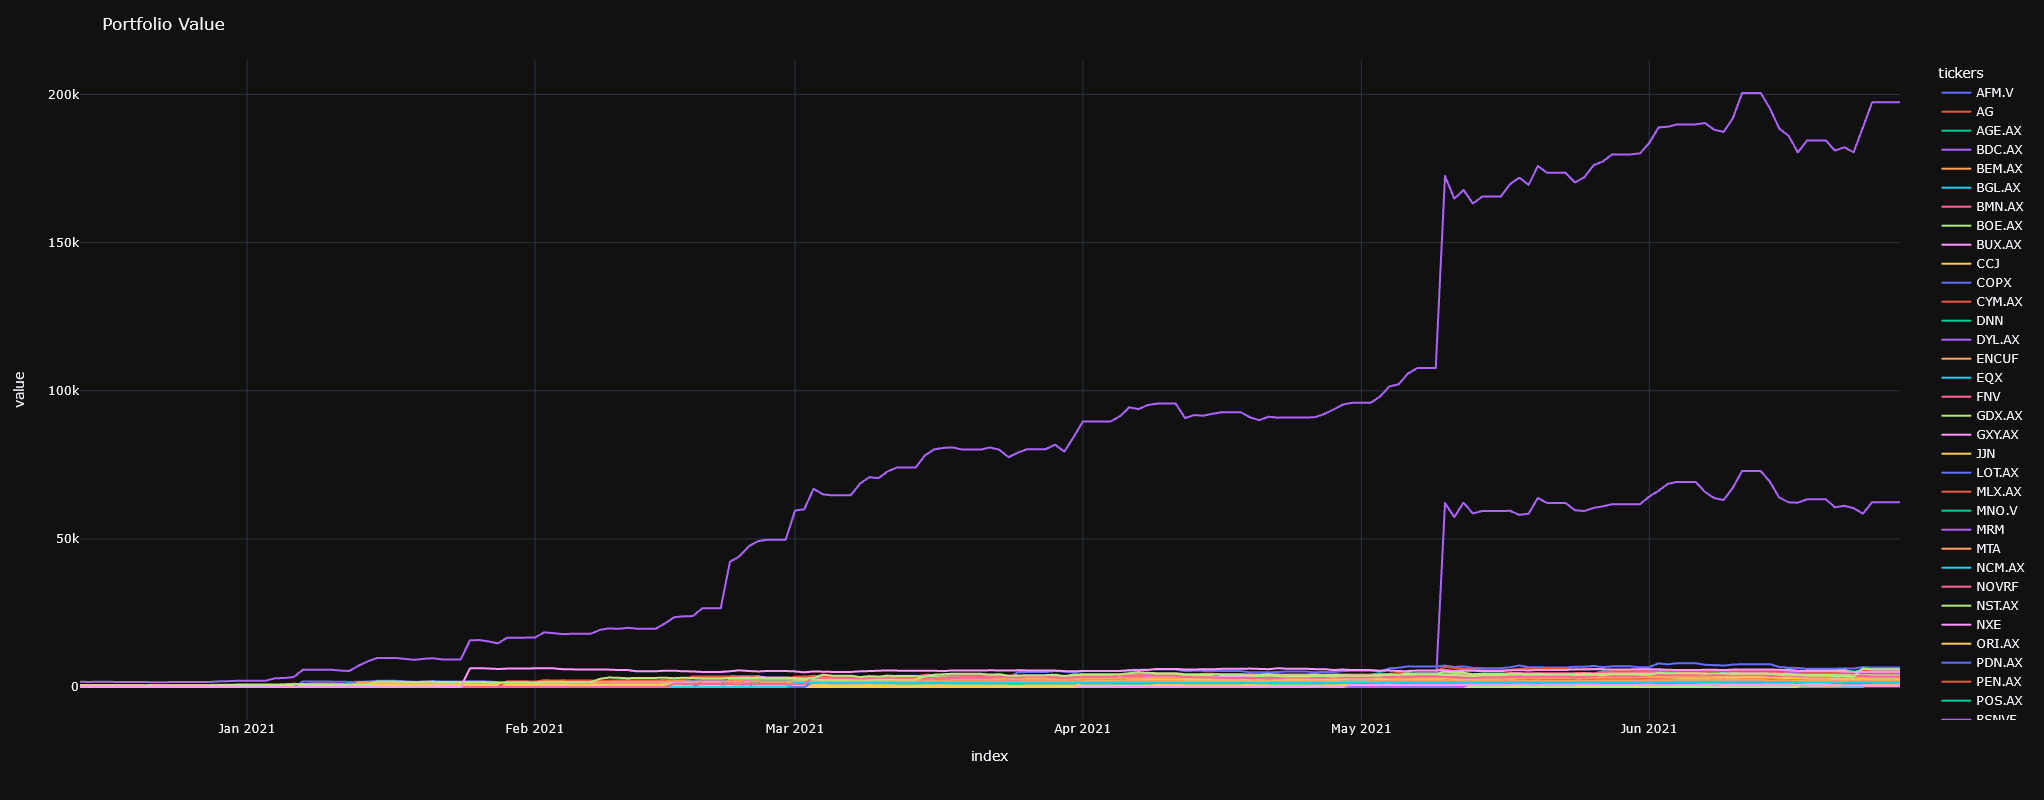

In [19]:
import plotly.express as px

fig = px.line(portfolio, width=1600, height=800)
fig.update_layout(xaxis_rangeslider_visible=False,
                 title='Portfolio Value',
                 template='plotly_dark')
fig.show()

In [33]:
tmp = portfolio.copy()
# tmp.head()
tmp.drop('Total', axis=1)
tmp.head()

tickers,AFM.V,AG,AGE.AX,BDC.AX,BEM.AX,BGL.AX,BMN.AX,BOE.AX,BUX.AX,CCJ,...,SRZ.AX,SUP.AX,SVL.AX,TMZ.AX,Total,URA,URNM,UUUU,VMY.AX,WGX.AX
2020-12-14,0.0,0.0,0.0,0.0,0.0,0.0,680.599974,491.399990,0.0,0.0,...,0.0,0.0,0.0,0.0,1781.999971,0.0,0.0,0.0,610.000007,0.0
2020-12-15,0.0,0.0,0.0,0.0,0.0,0.0,688.799991,475.199997,0.0,0.0,...,0.0,0.0,0.0,0.0,1693.999982,0.0,0.0,0.0,529.999994,0.0
2020-12-16,0.0,0.0,0.0,0.0,0.0,0.0,705.200024,480.600008,0.0,0.0,...,0.0,0.0,0.0,0.0,1815.800042,0.0,0.0,0.0,630.000010,0.0
2020-12-17,0.0,0.0,0.0,0.0,0.0,0.0,655.999985,475.199997,0.0,0.0,...,0.0,0.0,0.0,0.0,1761.199993,0.0,0.0,0.0,630.000010,0.0
2020-12-18,0.0,0.0,0.0,0.0,0.0,0.0,655.999985,448.199983,0.0,0.0,...,0.0,0.0,0.0,0.0,1704.199955,0.0,0.0,0.0,599.999987,0.0


In [51]:
portfolio.count()[0]-1

196

In [40]:
@interact()
def plot_pie(day=(0, portfolio.count()[0]-1)):
    tmp = portfolio.copy()
    tmp = tmp.drop('Total', axis=1)
    vec = tmp.iloc[day].to_numpy()[:-1]
    pylab.pie(vec, labels=tmp.columns[:-1], shadow = True, autopct='%1.1f%%', textprops={'color':"w"});
    fig = matplotlib.pyplot.gcf()
    fig.set_size_inches(18*2, 10*2)

interactive(children=(IntSlider(value=98, description='day', max=196), Output()), _dom_classes=('widget-intera…

## Animate me. 

In [44]:
for ii in range(portfolio.count()[0]-1):
    tmp = portfolio.copy()
    tmp = tmp.drop('Total', axis=1)
    vec = tmp.iloc[ii].to_numpy()[:-1]
    pylab.pie(vec, labels=tmp.columns[:-1], shadow = True, autopct='%1.1f%%', textprops={'color':"w"});
    fig = matplotlib.pyplot.gcf()
    fig.set_size_inches(18*1, 10*1)
    fig.savefig(f'./gif/{ii}.png')
    fig.clf()

<Figure size 1296x720 with 0 Axes>

In [53]:
portfolio.corr()

tickers,AFM.V,AG,AGE.AX,BDC.AX,BEM.AX,BGL.AX,BMN.AX,BOE.AX,BUX.AX,CCJ,...,SRZ.AX,SUP.AX,SVL.AX,TMZ.AX,Total,URA,URNM,UUUU,VMY.AX,WGX.AX
tickers,,,,,,,,,,,,,,,,,,,,,
AFM.V,1.000000,0.570584,0.780507,0.292729,0.102750,0.728951,0.689257,0.569050,0.511143,0.493849,...,0.553801,0.315967,0.452456,0.350050,0.690069,0.349015,0.413175,0.421148,0.395200,0.214021
AG,0.570584,1.000000,0.738462,0.754617,0.502359,0.744743,0.885685,0.830932,0.851648,0.932789,...,0.900506,0.793723,0.823322,0.733210,0.934157,0.641463,0.856378,0.840105,0.771484,0.523845
AGE.AX,0.780507,0.738462,1.000000,0.490546,0.323278,0.778607,0.837003,0.744596,0.649246,0.683847,...,0.666722,0.514254,0.633846,0.536133,0.846887,0.626073,0.601403,0.595183,0.704913,0.444902
BDC.AX,0.292729,0.754617,0.490546,1.000000,0.765382,0.733074,0.773666,0.884648,0.931438,0.890841,...,0.677077,0.922335,0.918945,0.969306,0.780618,0.706715,0.936534,0.938161,0.859962,0.666042
BEM.AX,0.102750,0.502359,0.323278,0.765382,1.000000,0.509328,0.525778,0.636434,0.686819,0.661961,...,0.464053,0.700475,0.760046,0.727364,0.547901,0.722168,0.692529,0.748212,0.818678,0.729444
BGL.AX,0.728951,0.744743,0.778607,0.733074,0.509328,1.000000,0.893527,0.898795,0.772756,0.795144,...,0.701701,0.705857,0.778529,0.735088,0.831030,0.600954,0.762900,0.767958,0.748649,0.505292
BMN.AX,0.689257,0.885685,0.837003,0.773666,0.525778,0.893527,1.000000,0.932922,0.857483,0.884579,...,0.797173,0.809390,0.830440,0.785982,0.940692,0.686946,0.871482,0.856269,0.820029,0.546022
BOE.AX,0.569050,0.830932,0.744596,0.884648,0.636434,0.898795,0.932922,1.000000,0.889706,0.897935,...,0.738615,0.864551,0.881140,0.891696,0.890247,0.696782,0.912514,0.904694,0.869737,0.600144
BUX.AX,0.511143,0.851648,0.649246,0.931438,0.686819,0.772756,0.857483,0.889706,1.000000,0.929915,...,0.763782,0.882119,0.952373,0.936336,0.913647,0.722873,0.928092,0.930490,0.850256,0.644100


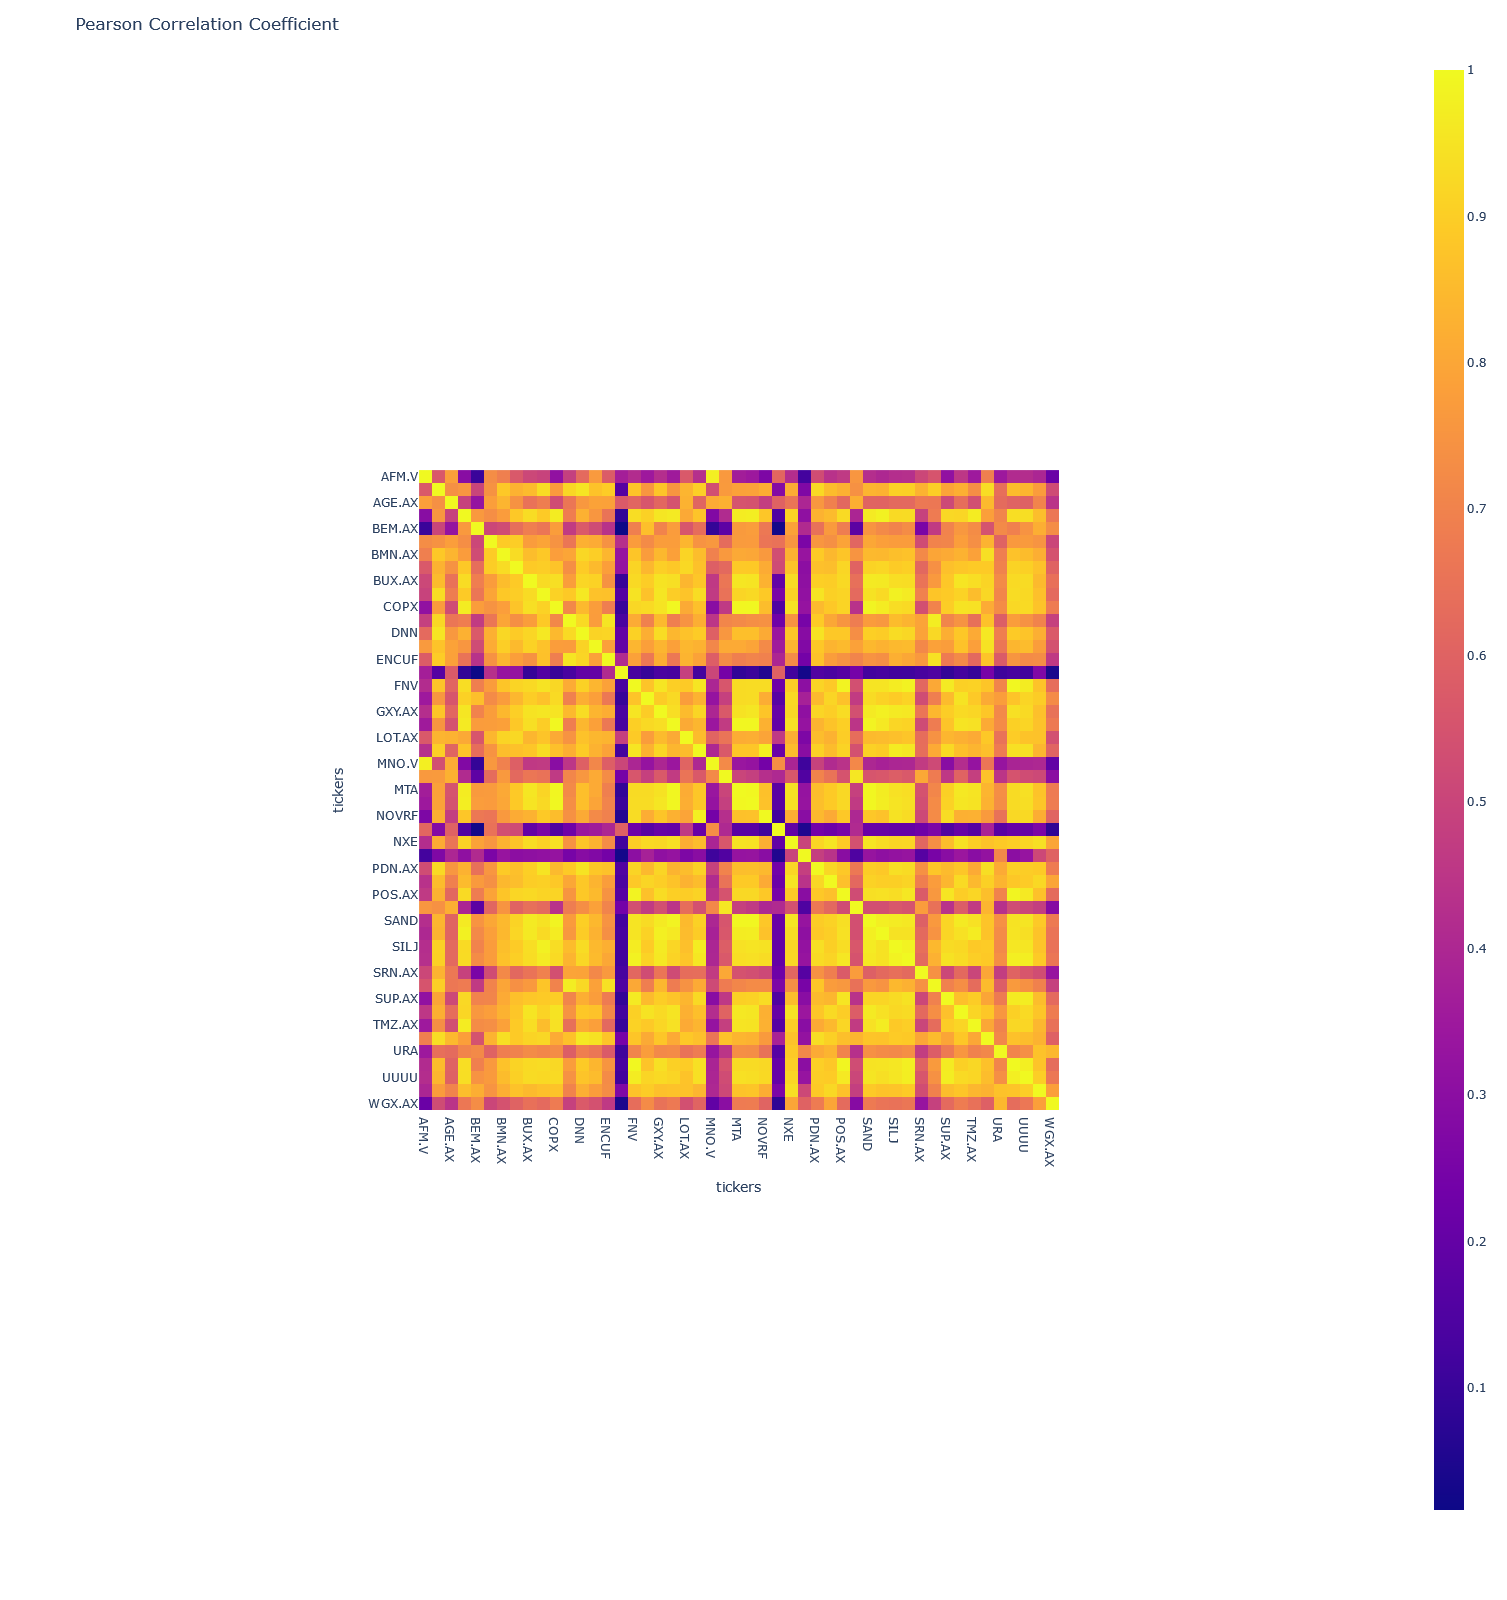

In [54]:
import plotly.express as px

fig = px.imshow(portfolio.corr(), width=1600*2, height=800*2)
fig.update_layout(
    title= 'Pearson Correlation Coefficient')
fig.show()

In [68]:
import os
path = './gif'
for filename in os.listdir(path):
    num = filename.split('.')[0]
    num = num.zfill(4)
    new_filename = num + ".png"
    os.rename(os.path.join(path, filename), os.path.join(path, new_filename))

FileExistsError: [WinError 183] Cannot create a file when that file already exists: './gif\\0000.png' -> './gif\\0000.jpg'

In [70]:
# image = Image.open("test.png").convert("RGBA")
# new_image = Image.new("RGBA", image.size, "WHITE")
# new_image.paste(image, mask=image)

# new_image.convert("RGB").save("test.jpg")


from PIL import Image
import glob
 
# Create the frames
frames = []
imgs = glob.glob("./gif/*.png")
for i in imgs:
    frame = Image.open(i).convert("RGBA")
    new_frame = Image.new("RGBA", frame.size, "BLACK")
    new_frame.paste(frame, mask=frame)
    frames.append(new_frame)
 
# Save into a GIF file that loops forever
frames[0].save('png_to_gif.gif', format='GIF',
               append_images=frames[1:],
               save_all=True,
               duration=200, loop=0)